In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import numpy as np
from tqdm.notebook import tqdm

from scipy.stats import gaussian_kde
import time
import sys
sys.path.append('../')
from utils import plot as plot_utils, s3w as s3w_utils, vmf as vmf_utils, misc as utils, swae as swae_utils
from methods.s3wd import s3wd, ri_s3wd, ari_s3wd
from methods.sswd import sswd

In [14]:
device = 'cuda:1'

In [15]:
def scatter_mollweide_ax(X, ax, c=None,s=3,cmap='tab10'):
    '''
    https://github.com/clbonet/Spherical_Sliced-Wasserstein/blob/main/lib/utils_sphere.py
    '''
    spherical_coords = utils.euclidean_to_spherical(X)
    ax.scatter(spherical_coords[:,0] - np.pi, spherical_coords[:,1] - np.pi/2, c=c,s=s,cmap=cmap)
    ax.set_axis_off()

In [4]:
# Define a Convolutional Autoencoder model
class ConvAutoencoder(nn.Module):
    def __init__(self, embedding_dim=8):
        super(ConvAutoencoder, self).__init__()
        self.embedding_dim = embedding_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=0),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=0, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1),
              nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=0, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=0),
            nn.Sigmoid(),
        )
        self.embedding_encoder = nn.Sequential(
            nn.Linear(128 * 2 * 2, 512),
            nn.ReLU(),
            nn.Linear(512, embedding_dim)
            )
        self.embedding_decoder = nn.Sequential(
            nn.Linear(embedding_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 128 * 2 * 2)
            )

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten        
        embedding = self.embedding_encoder(x)
        embedding = embedding/torch.norm(embedding,p=2,dim=-1,keepdim=True)
        xhat = self.decoder(self.embedding_decoder(embedding).view(x.size(0), 128, 2, 2))
        return xhat, embedding

    def sample(self, n):
        samples = torch.randn(n, self.embedding_dim).to(device)
        samples = samples/torch.norm(samples,p=2,dim=-1,keepdim=True)
        samples = self.decoder(self.embedding_decoder(samples).view(n, 128, 2, 2))
        return samples

In [5]:
# Define training parameters
batch_size = 500
learning_rate = 1e-3
num_epochs = 100

In [25]:
# Data loading and preprocessing
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [31]:
test_data = torch.zeros((10000, 1, 28, 28))

for i, (data, label) in enumerate(test_loader):
    test_data[i*batch_size:(i+1)*batch_size] = data

In [7]:
# Initialize the model and optimizer
# model = ConvAutoencoder(embedding_dim=3)
# model = model.to(device)
# criterion1 = nn.BCELoss()
# criterion2 = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
# Training loop
# train_time_AE = []
# for epoch in tqdm(range(num_epochs)):
#     tic = time.time()
#     for data in train_loader:
#         images, _ = data
#         images = images.to(device)
#         optimizer.zero_grad()        
#         outputs, _ = model(images)
#         loss = criterion1(outputs, images)+criterion2(outputs, images)
#         loss.backward()
#         optimizer.step()
#     toc = time.time()
#     train_time_AE.append(toc-tic)
#     print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
# torch.save(model.state_dict(), './AE.pt')
# model.load_state_dict(torch.load('./AE.pt'))

In [9]:
# embeddings = []
# labels = []
# BCE = []
# MSE = []
# for data in test_loader:
#     images, y = data    
#     images = images.to(device)
#     outputs, embedding = model(images)
#     BCE.append(nn.BCELoss(reduce=False)(outputs,images).mean(dim=[1,2,3]).detach().cpu())
#     MSE.append(nn.MSELoss(reduce=False)(outputs,images).mean(dim=[1,2,3]).detach().cpu())
#     embeddings.append(embedding.detach().cpu())
#     labels.append(y)

# embeddings = torch.cat(embeddings)
# labels = torch.cat(labels).numpy()
# k = gaussian_kde(embeddings.numpy().T)
# fig, ax = plt.subplots(1, 2, figsize=(20,10), subplot_kw={'projection': "mollweide"})
# scatter_mollweide_ax(embeddings,ax[0],c=labels)
# plot_utils.projection_mollweide(lambda x: k.pdf(x.T), ax[1])
# plt.savefig('aep.pdf', bbox_inches='tight', dpi=100)
# plt.show()

# fig, ax = plt.subplots(3,10,figsize=(20,6))
# for i in range(3):
#     for j in range(5):        
#         ax[i,2*j].imshow(images[i*5+j,...].squeeze().detach().cpu(),cmap='gray')
#         ax[i,2*j+1].imshow(outputs[i*5+j,...].squeeze().detach().cpu(),cmap='gray')
#         ax[i,2*j].axis('off')
#         ax[i,2*j+1].axis('off')
# plt.savefig('aes.pdf', bbox_inches='tight', dpi=100)
# plt.show()

# print(torch.cat(BCE).mean(),torch.cat(BCE).std())

In [10]:
# Initialize the model and optimizer
model = ConvAutoencoder(embedding_dim=3)
model = model.to(device)
criterion1 = nn.BCELoss()
# criterion2 = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
# Training loop
# model.load_state_dict(torch.load('/home/kolous2/Documents/s3wd/AE.pt'))
beta = 0.1
num_epochs = 100
for epoch in tqdm(range(num_epochs)):
    for data in train_loader:
        images, _ = data
        images = images.to(device)
        optimizer.zero_grad()
        outputs, embedding = model(images)
        prior = torch.randn_like(embedding)
        prior /= torch.norm(prior,p=2,dim=-1,keepdim=True)
        loss1 = criterion1(outputs, images)
        loss2 = ri_s3wd(embedding,prior,p=2,n_rotations=1,n_projs=64,device=device)**2
        loss = loss1+beta*loss2
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss1: {loss1.item():.4f}, Loss2: {loss2.item():.4f}')
torch.save(model.state_dict(), './AE_RI1_S3WD_1.pt')

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100], Loss1: 0.2999, Loss2: 23.7972
Epoch [2/100], Loss1: 0.2653, Loss2: 4.8485
Epoch [3/100], Loss1: 0.2486, Loss2: 1.1201
Epoch [4/100], Loss1: 0.2448, Loss2: 8.8165
Epoch [5/100], Loss1: 0.2401, Loss2: 8.0966
Epoch [6/100], Loss1: 0.2394, Loss2: 0.4463
Epoch [7/100], Loss1: 0.2370, Loss2: 0.7351
Epoch [8/100], Loss1: 0.2407, Loss2: 2.0323
Epoch [9/100], Loss1: 0.2356, Loss2: 5.8265
Epoch [10/100], Loss1: 0.2392, Loss2: 2.8958
Epoch [11/100], Loss1: 0.2351, Loss2: 2.6089
Epoch [12/100], Loss1: 0.2336, Loss2: 0.2455
Epoch [13/100], Loss1: 0.2391, Loss2: 24.0766
Epoch [14/100], Loss1: 0.2330, Loss2: 1.6831
Epoch [15/100], Loss1: 0.2350, Loss2: 0.8095
Epoch [16/100], Loss1: 0.2391, Loss2: 0.8635
Epoch [17/100], Loss1: 0.2322, Loss2: 0.2173
Epoch [18/100], Loss1: 0.2342, Loss2: 1.3764
Epoch [19/100], Loss1: 0.2315, Loss2: 1.7595
Epoch [20/100], Loss1: 0.2320, Loss2: 0.2039
Epoch [21/100], Loss1: 0.2306, Loss2: 1.5975
Epoch [22/100], Loss1: 0.2339, Loss2: 2.3495
Epoch [23/100], L

/home/kothapa/miniconda3/envs/dev/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


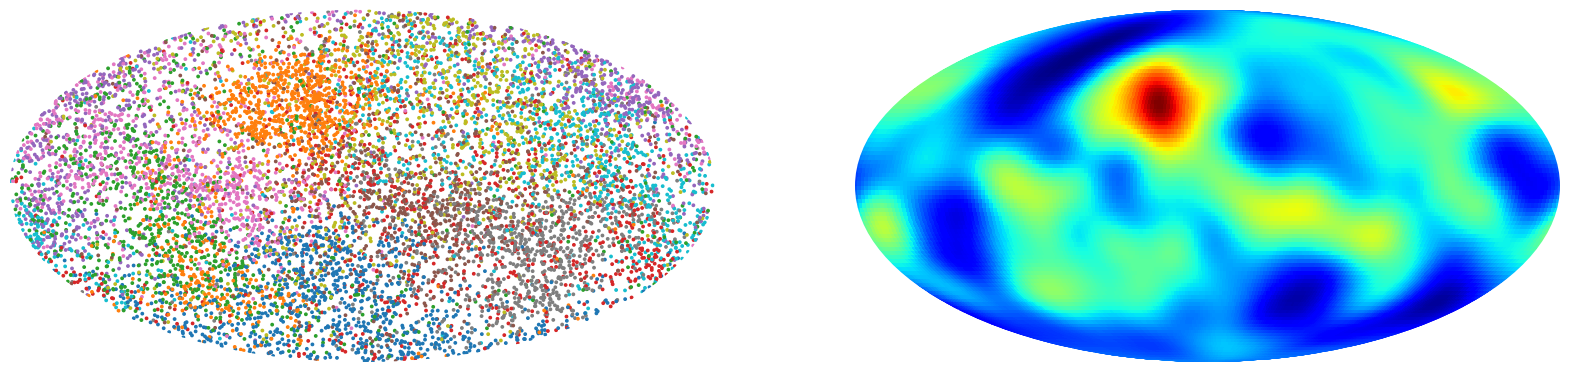

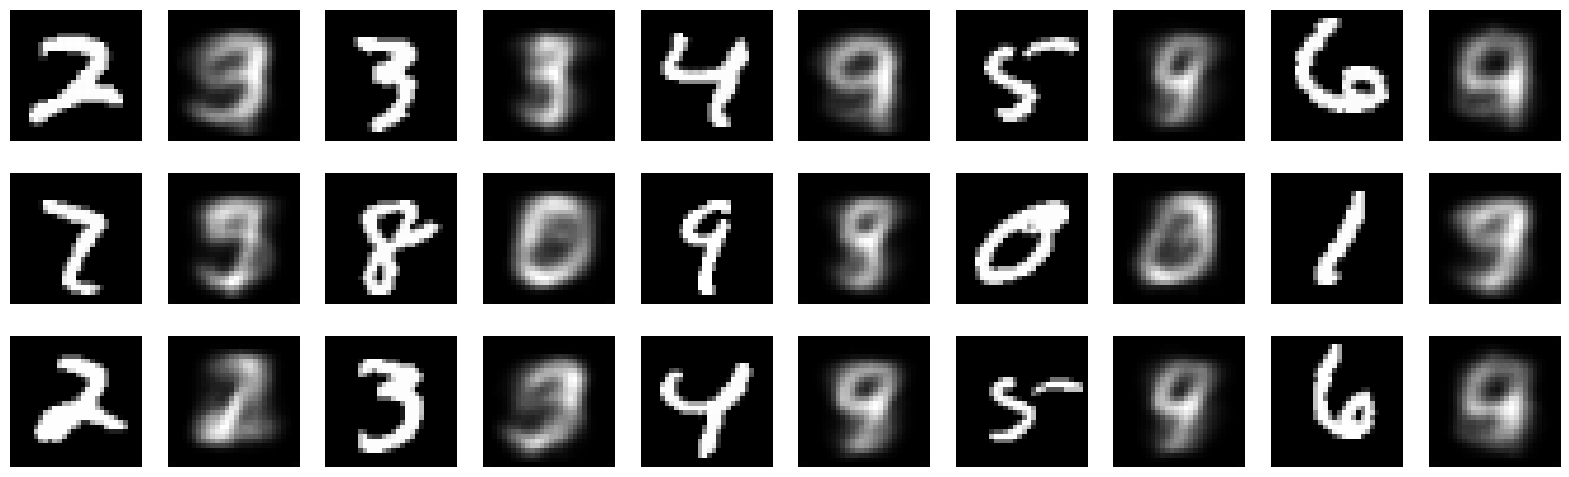

tensor(0.2332) tensor(0.0622)


In [16]:
embeddings = []
labels = []
BCE = []
for data in test_loader:
    images, y = data    
    images = images.to(device)
    outputs, embedding = model(images)
    BCE.append(nn.BCELoss(reduce=False)(outputs,images).mean(dim=[1,2,3]).detach().cpu())
    embeddings.append(embedding.detach().cpu())
    labels.append(y)

embeddings = torch.cat(embeddings)
labels = torch.cat(labels).numpy()
k = gaussian_kde(embeddings.numpy().T)
fig, ax = plt.subplots(1, 2, figsize=(20,10), subplot_kw={'projection': "mollweide"})
scatter_mollweide_ax(embeddings,ax[0],c=labels)
plot_utils.projection_mollweide(lambda x: k.pdf(x.T), ax[1])
# plt.savefig('./aep_ri1.pdf', bbox_inches='tight', dpi=200)
plt.show()

fig, ax = plt.subplots(3,10,figsize=(20,6))
for i in range(3):
    for j in range(5):        
        ax[i,2*j].imshow(images[i*5+j,...].squeeze().detach().cpu(),cmap='gray')
        ax[i,2*j+1].imshow(outputs[i*5+j,...].squeeze().detach().cpu(),cmap='gray')
        ax[i,2*j].axis('off')
        ax[i,2*j+1].axis('off')
# plt.savefig('./aes_ri1.pdf', bbox_inches='tight', dpi=200)
plt.show()

print(torch.cat(BCE).mean(),torch.cat(BCE).std())

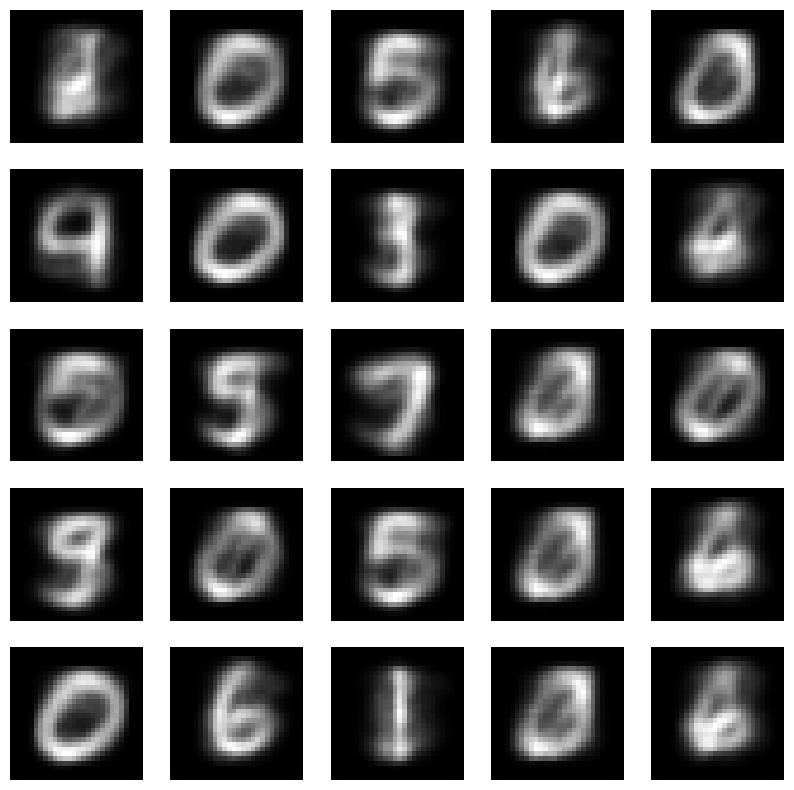

In [36]:
fig, ax = plt.subplots(5,5,figsize=(10,10))

outputs = model.sample(25)
for i in range(5):
    for j in range(5):        
        ax[i,j].imshow(outputs[i*5+j,...].squeeze().detach().cpu(),cmap='gray')
        ax[i,j].axis('off')
# plt.savefig('./aes_ri1.pdf', bbox_inches='tight', dpi=200)
plt.show()

In [34]:
L = []
for k in range(10):
    gen_imgs = model.sample(10000).cpu().detach()

    fid = swae_utils.evaluate_fid_score(test_data.reshape(-1,28,28,1), gen_imgs.reshape(-1,28,28,1), batch_size=50)
    L.append(fid)
    
print(np.mean(L), np.std(L))

/home/kothapa/miniconda3/envs/dev/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kothapa/miniconda3/envs/dev/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


206.1381218155851 0.3750464501256751


In [44]:
# Initialize the model and optimizer
model = ConvAutoencoder(embedding_dim=3)
model = model.to(device)
criterion1 = nn.BCELoss()
# criterion2 = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [45]:
# Training loop
# model.load_state_dict(torch.load('/home/kolous2/Documents/s3wd/AE.pt'))
beta = 1e-3
num_epochs = 100
train_time = []
for epoch in tqdm(range(num_epochs)):
    for data in train_loader:
        images, _ = data
        images = images.to(device)
        optimizer.zero_grad()
        tic = time.time()
        outputs, embedding = model(images)
        prior = torch.randn_like(embedding)
        prior /= torch.norm(prior,p=2,dim=-1,keepdim=True)
        loss1 = criterion1(outputs, images)
        loss2 = s3wd(embedding,prior,p=2,n_projs=64,device=device)**2
        loss = loss1+beta*loss2
        loss.backward()
        optimizer.step()
        toc = time.time()
        train_time.append(toc-tic)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss1: {loss1.item():.4f}, Loss2: {loss2.item():.4f}')
torch.save(model.state_dict(), './AE_S3WD.pt')    

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100], Loss1: 0.2666, Loss2: 11.1282
Epoch [2/100], Loss1: 0.2448, Loss2: 2.2227
Epoch [3/100], Loss1: 0.2314, Loss2: 0.9465
Epoch [4/100], Loss1: 0.2265, Loss2: 0.2300
Epoch [5/100], Loss1: 0.2214, Loss2: 0.2202
Epoch [6/100], Loss1: 0.2149, Loss2: 0.6394
Epoch [7/100], Loss1: 0.2087, Loss2: 0.3262
Epoch [8/100], Loss1: 0.2045, Loss2: 9.3158
Epoch [9/100], Loss1: 0.1999, Loss2: 1.1076
Epoch [10/100], Loss1: 0.2039, Loss2: 1.4610
Epoch [11/100], Loss1: 0.1938, Loss2: 0.4715
Epoch [12/100], Loss1: 0.1901, Loss2: 2.1616
Epoch [13/100], Loss1: 0.1920, Loss2: 1.1643
Epoch [14/100], Loss1: 0.1887, Loss2: 4.1029
Epoch [15/100], Loss1: 0.1907, Loss2: 0.7263
Epoch [16/100], Loss1: 0.1842, Loss2: 2.5422
Epoch [17/100], Loss1: 0.1874, Loss2: 2.5082
Epoch [18/100], Loss1: 0.1938, Loss2: 0.9280
Epoch [19/100], Loss1: 0.1805, Loss2: 0.8053
Epoch [20/100], Loss1: 0.1793, Loss2: 0.8273
Epoch [21/100], Loss1: 0.1824, Loss2: 2.9563
Epoch [22/100], Loss1: 0.1879, Loss2: 4.2777
Epoch [23/100], Lo

tensor(0.1194)


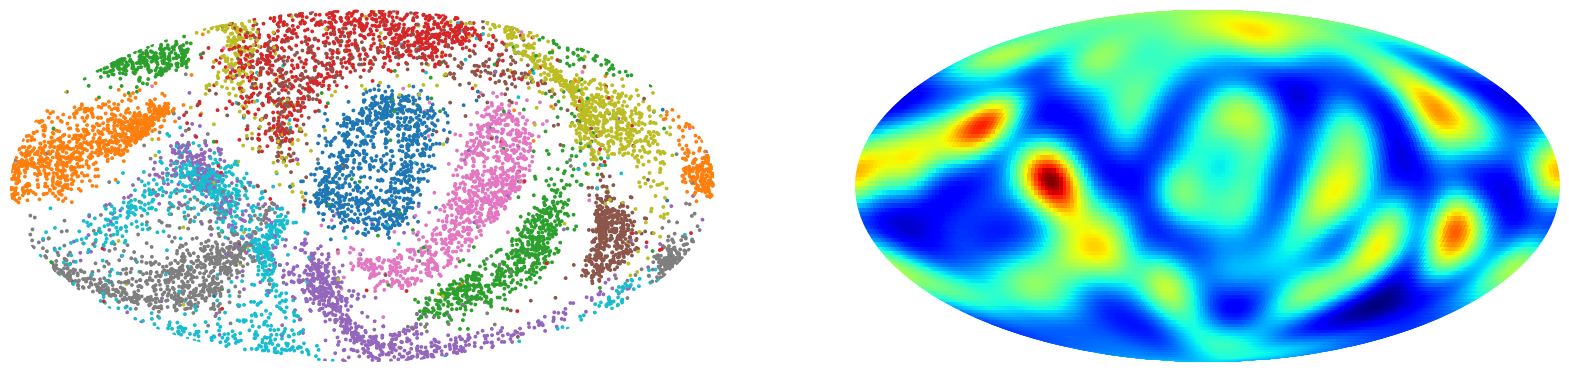

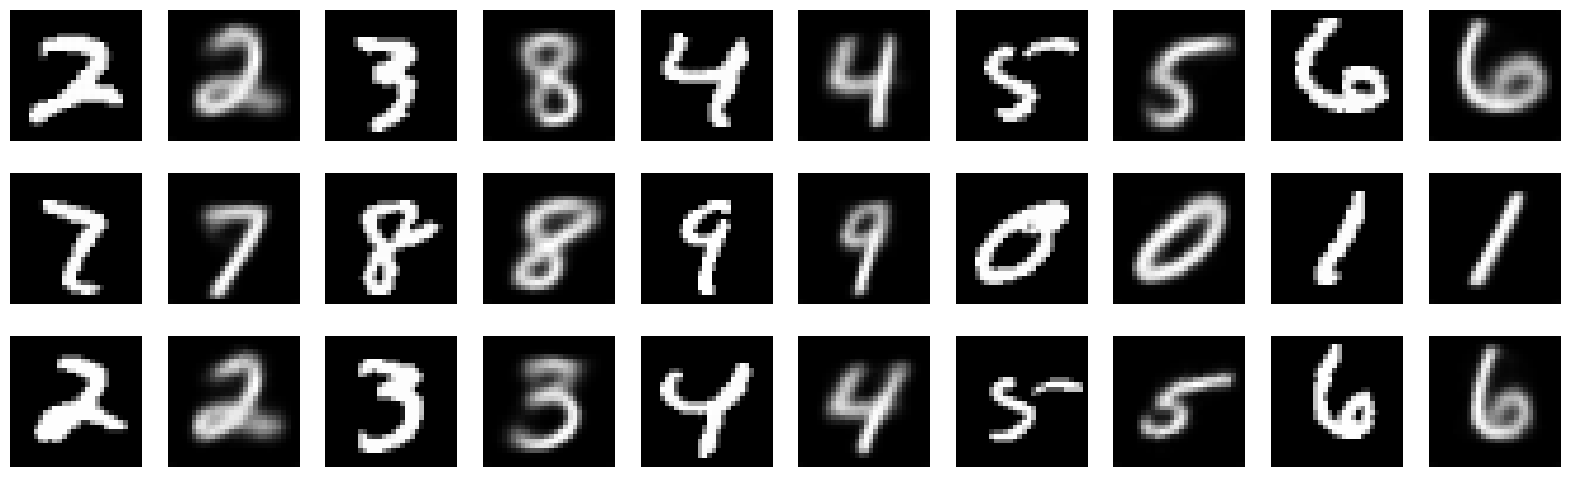

tensor(0.1668) tensor(0.0630)
0.11935754865407944 nan


In [57]:
embeddings = []
labels = []
BCE = []
from methods.w import sph_wasserstein
def rand_unif(N, d, device):
    samples = torch.randn(N, d, device=device)
    samples_ = samples / samples.norm(dim=1, keepdim=True)
    return samples_

for data in test_loader:
    images, y = data    
    images = images.to(device)
    outputs, embedding = model(images)
    BCE.append(nn.BCELoss(reduce=False)(outputs,images).mean(dim=[1,2,3]).detach().cpu())
    embeddings.append(embedding.detach().cpu())
    labels.append(y)


embeddings = torch.cat(embeddings)


sphere_samples = rand_unif(embeddings.size(0), embeddings.size(1), device)


embeddings = embeddings.to(device) 


W2_dist = sph_wasserstein(embeddings, sphere_samples)
print(W2_dist)
avg_test_W2 = W2_dist.mean().item()
std_w2 = W2_dist.std().item()
embeddings=embeddings.cpu()
labels = torch.cat(labels).numpy()
k = gaussian_kde(embeddings.numpy().T)
fig, ax = plt.subplots(1, 2, figsize=(20,10), subplot_kw={'projection': "mollweide"})
scatter_mollweide_ax(embeddings,ax[0],c=labels)
plot_utils.projection_mollweide(lambda x: k.pdf(x.T), ax[1])
plt.savefig('./aep_s3w1.pdf', bbox_inches='tight', dpi=200)
plt.show()

fig, ax = plt.subplots(3,10,figsize=(20,6))
for i in range(3):
    for j in range(5):        
        ax[i,2*j].imshow(images[i*5+j,...].squeeze().detach().cpu(),cmap='gray')
        ax[i,2*j+1].imshow(outputs[i*5+j,...].squeeze().detach().cpu(),cmap='gray')
        ax[i,2*j].axis('off')
        ax[i,2*j+1].axis('off')
plt.savefig('./aes_s3w1.pdf', bbox_inches='tight', dpi=200)
plt.show()

print(torch.cat(BCE).mean(),torch.cat(BCE).std())
print(avg_test_W2,std_w2)

In [70]:
# Training loop
model.load_state_dict(torch.load('/home/kolous2/Documents/s3wd/AE.pt'))
beta = 1e+3
num_epochs = 25
for epoch in tqdm(range(num_epochs)):
    for data in train_loader:
        images, _ = data
        images = images.to(device)
        optimizer.zero_grad()
        outputs, embedding = model(images)
        prior = torch.randn_like(embedding)
        prior /= torch.norm(prior,p=2,dim=-1,keepdim=True)
        loss1 = criterion1(outputs, images)
        loss2 = sswd(embedding,prior,p=2,num_projections=64,device=device)
        loss = loss1+beta*loss2
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss1: {loss1.item():.4f}, Loss2: {loss2.item():.4f}')
torch.save(model.state_dict(), '/home/kolous2/Documents/s3wd/AE_SSWD.pt')    

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch [1/25], Loss1: 0.1703, Loss2: 0.0015
Epoch [2/25], Loss1: 0.1826, Loss2: 0.0008
Epoch [3/25], Loss1: 0.1753, Loss2: 0.0012
Epoch [4/25], Loss1: 0.1728, Loss2: 0.0006
Epoch [5/25], Loss1: 0.1716, Loss2: 0.0024
Epoch [6/25], Loss1: 0.1680, Loss2: 0.0029
Epoch [7/25], Loss1: 0.1780, Loss2: 0.0010
Epoch [8/25], Loss1: 0.1745, Loss2: 0.0010
Epoch [9/25], Loss1: 0.1683, Loss2: 0.0013
Epoch [10/25], Loss1: 0.1713, Loss2: 0.0010
Epoch [11/25], Loss1: 0.1837, Loss2: 0.0012
Epoch [12/25], Loss1: 0.1933, Loss2: 0.0022
Epoch [13/25], Loss1: 0.1852, Loss2: 0.0010
Epoch [14/25], Loss1: 0.1773, Loss2: 0.0011
Epoch [15/25], Loss1: 0.1703, Loss2: 0.0026
Epoch [16/25], Loss1: 0.1697, Loss2: 0.0009
Epoch [17/25], Loss1: 0.1670, Loss2: 0.0017
Epoch [18/25], Loss1: 0.1743, Loss2: 0.0019
Epoch [19/25], Loss1: 0.1665, Loss2: 0.0015
Epoch [20/25], Loss1: 0.1801, Loss2: 0.0008
Epoch [21/25], Loss1: 0.1690, Loss2: 0.0014
Epoch [22/25], Loss1: 0.1722, Loss2: 0.0012
Epoch [23/25], Loss1: 0.1658, Loss2: 0.00

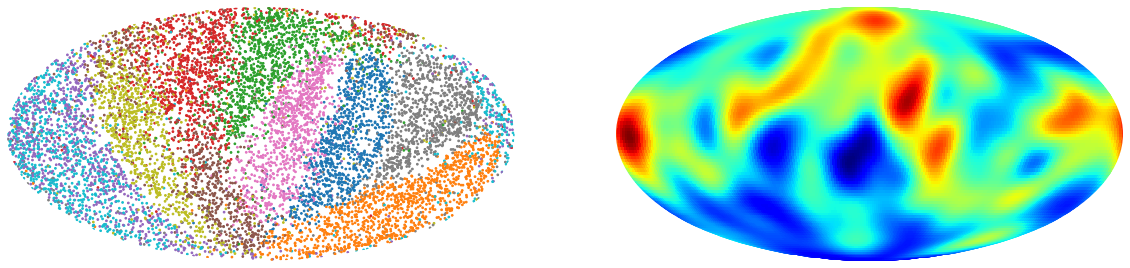

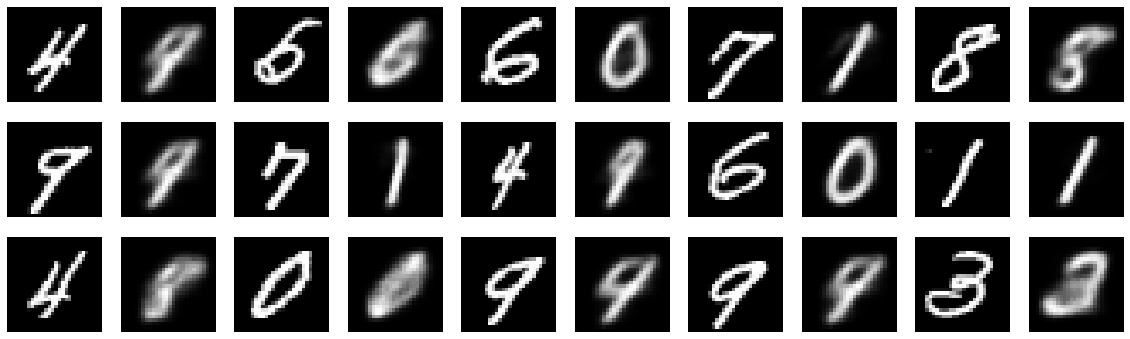

tensor(0.1791) tensor(0.0694)


In [29]:
embeddings = []
labels = []
BCE = []
for data in test_loader:
    images, y = data    
    images = images.to(device)
    outputs, embedding = model(images)
    BCE.append(nn.BCELoss(reduce=False)(outputs,images).mean(dim=[1,2,3]).detach().cpu())
    embeddings.append(embedding.detach().cpu())
    labels.append(y)

embeddings = torch.cat(embeddings)
labels = torch.cat(labels).numpy()
k = gaussian_kde(embeddings.numpy().T)
fig, ax = plt.subplots(1, 2, figsize=(20,10), subplot_kw={'projection': "mollweide"})
scatter_mollweide_ax(embeddings,ax[0],c=labels)
plot_utils.projection_mollweide(lambda x: k.pdf(x.T), ax[1])
plt.show()

fig, ax = plt.subplots(3,10,figsize=(20,6))
for i in range(3):
    for j in range(5):        
        ax[i,2*j].imshow(images[i*5+j,...].squeeze().detach().cpu(),cmap='gray')
        ax[i,2*j+1].imshow(outputs[i*5+j,...].squeeze().detach().cpu(),cmap='gray')
        ax[i,2*j].axis('off')
        ax[i,2*j+1].axis('off')
plt.show()

print(torch.cat(BCE).mean(),torch.cat(BCE).std())

In [46]:
def fibonacci_sphere(samples=1000):
    points = []
    phi = np.pi * (np.sqrt(5.) - 1.)  # golden angle in radians
    y = 1 - 2*np.arange(samples)/float(samples-1)
    radius = np.sqrt(1-y**2)
    theta = phi*np.arange(samples)
    x = np.cos(theta) * radius
    z = np.sin(theta) * radius
    points = np.stack([x,y,z],axis=-1)
    return points

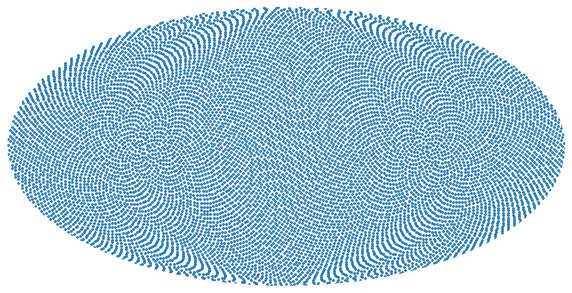

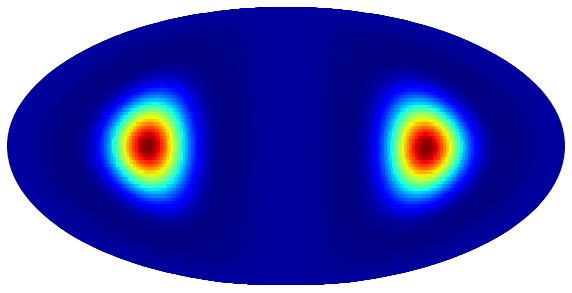

In [73]:
prior = fibonacci_sphere(10000)
fig, ax = plt.subplots(1, 1, figsize=(10,10), subplot_kw={'projection': "mollweide"})
scatter_mollweide_ax(prior,ax)
plt.show()
k = gaussian_kde(prior.T,bw_method=.5)
fig, ax = plt.subplots(1, 1, figsize=(10,10), subplot_kw={'projection': "mollweide"})
plot_utils.projection_mollweide(lambda x: k.pdf(x.T), ax)
plt.show()

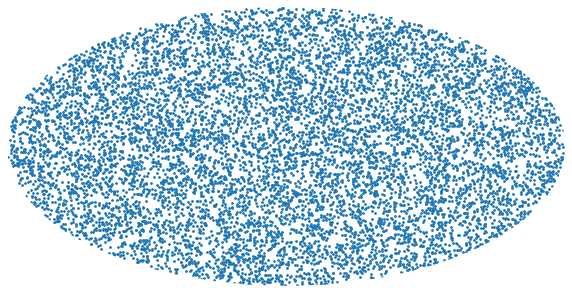

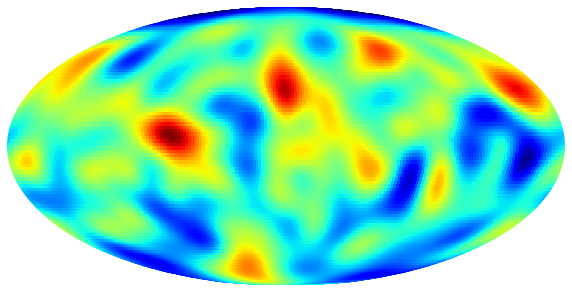

In [72]:
prior = np.random.randn(10000,3)
prior/= np.linalg.norm(prior,ord=2,axis=-1,keepdims=True)
fig, ax = plt.subplots(1, 1, figsize=(10,10), subplot_kw={'projection': "mollweide"})
scatter_mollweide_ax(prior,ax)
plt.show()
k = gaussian_kde(prior.T)
fig, ax = plt.subplots(1, 1, figsize=(10,10), subplot_kw={'projection': "mollweide"})
plot_utils.projection_mollweide(lambda x: k.pdf(x.T), ax)
plt.show()